# Resource estimation

In [2]:
from functools import partial
import numpy as np
from matplotlib import pyplot as plt
from quantum_simulation_recipe.plot_config import *
# from quantum_simulation_recipe.bounds import tight_bound
from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
from resource_estimation import *

fig_dir, data_dir = './figs', './data'

## The worst-case (state-independent) Trotter error bound

In [3]:
from quantum_simulation_recipe.trotter import pf, pf_high, expH

J, h, pbc, group = 2, 1, True, 'xyz'
# J, h, pbc, group = 2, 1, True, 'par'
model_par = {'Jz': J, 'hx': h, 'pbc': pbc, 'group': group}

t, r = 10, 100
n_list = np.array([4, 6, 8, 10, 12])
# n_list = np.arange(4, 12)
emp_err_list, thm_err_list = [], []

for n in n_list:
    nnh = Nearest_Neighbour_1d(n, Jz=J, hx=h, pbc=pbc)
    if group == 'xyz':
        H_list = [term.to_matrix() for term in nnh.ham_xyz]
    elif group == 'par':
        H_list = [term.to_matrix() for term in nnh.ham_par]
    # appro_U, exact_U = pf(H_list, t, r, order=2, use_jax=True, return_exact=True)
    appro_U, exact_U = pf(H_list, t/r, 1, order=2, use_jax=True, return_exact=True)
    emp_err_list.append(np.linalg.norm(appro_U - exact_U, ord=2))
    err_bound = tight_bound(H_list, 2, t/r, 1)
    thm_err_list.append(err_bound)
    # thm_err_list.append(tight_bound(H_list, 2, t, r))
    print(f'n={n}; {err_bound}') 

emp_err_list, thm_err_list = np.array(emp_err_list), np.array(thm_err_list)

n=4; 0.01885618083164127
n=6; 0.026666666666666675
n=8; 0.03484167906337006
n=10; 0.04314757303333056
n=12; 0.051516044068750384


grouping: xyz
a_em: 0.0040900316432270975; b_em: 0.0022853755858799557
a_em: 0.0021638829260554556; b_em: 0.0009495105598476377


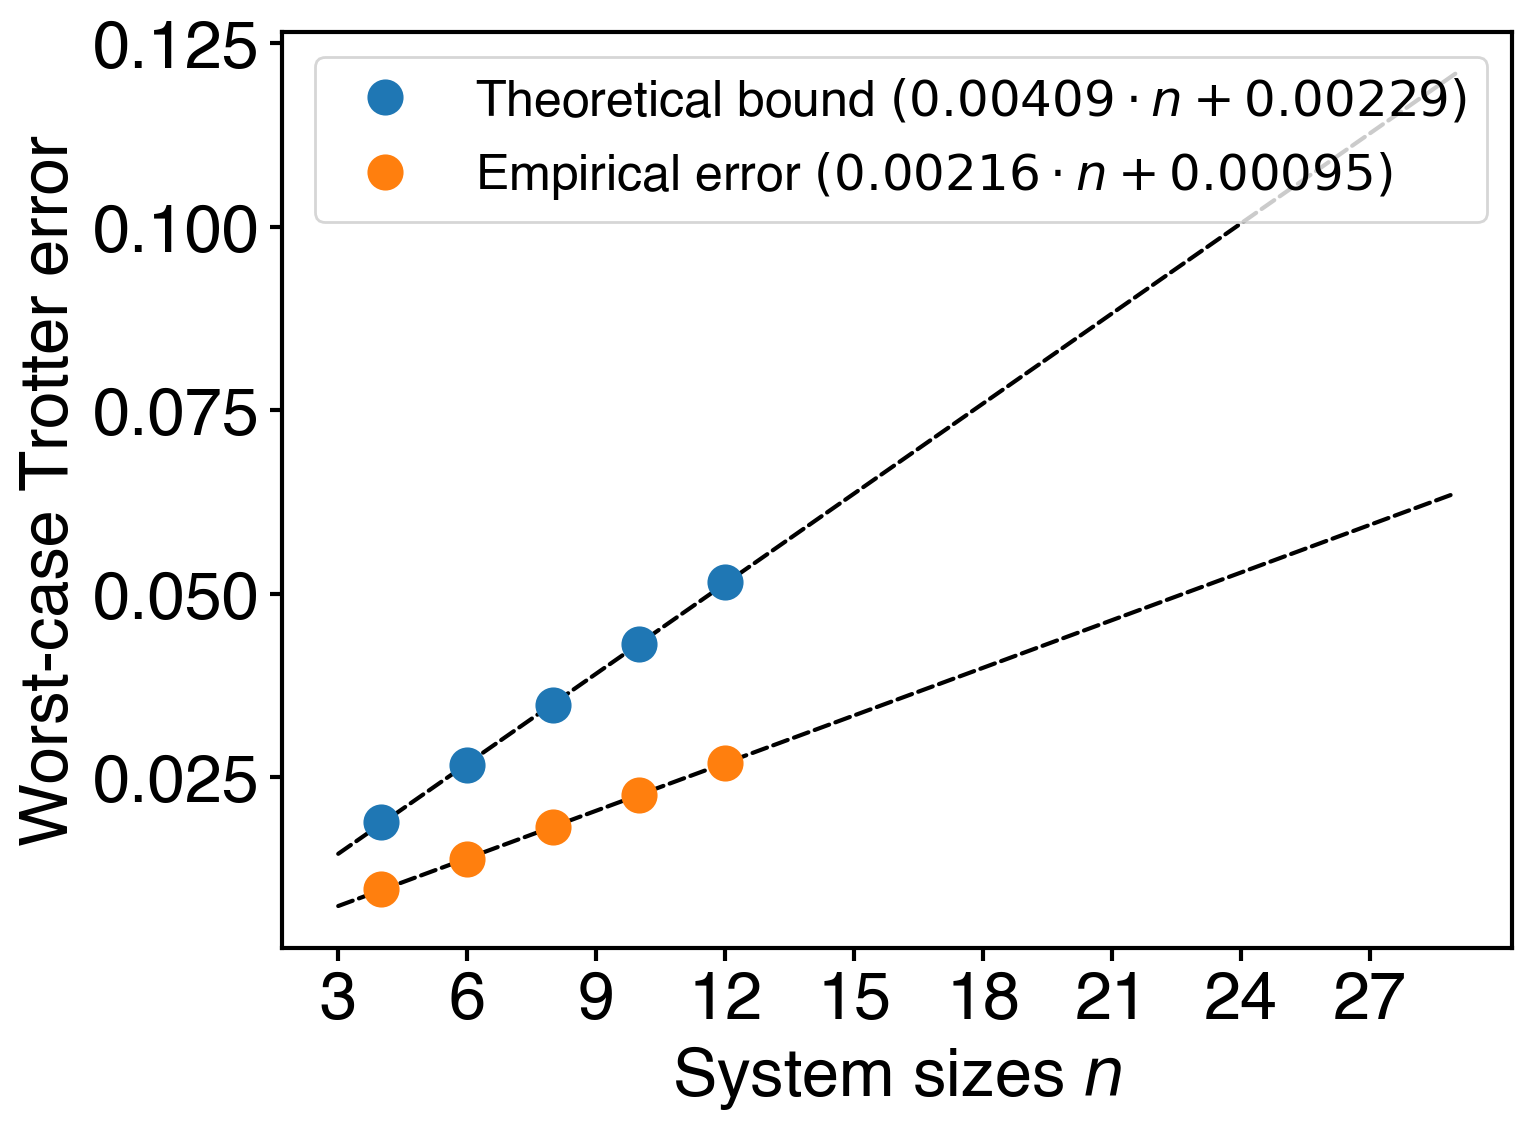

In [4]:
print(f'grouping: {group}')
set_fontsize(medium=MEDIUM_SIZE, large=LARGE_SIZE, linewidth=1.5)
fig, ax = plt.subplots(1, 1)
n_list_ext = list(np.arange(3, 30))
slope, intercept = plot_fit(ax, n_list, thm_err_list, var='n', log_axis='', ext_x=n_list_ext, annotate=False)
slope_emp, intercept_emp = plot_fit(ax, n_list, emp_err_list, var='n', log_axis='', ext_x=n_list_ext, annotate=False)

text_slope, text_intercept = "{:.5f}".format(round(slope, 5)), "{:.5f}".format(round(intercept, 5))
# text_slope, text_intercept = "{:.4f}".format(round(slope*(r/t)**3, 4)), "{:.4f}".format(round(intercept, 4))
ax.plot(n_list, thm_err_list, 'o', label=r'Theoretical bound $(%s \cdot %s + %s )$' % (text_slope, 'n', text_intercept))

text_slope_emp, text_intercept_emp = "{:.5f}".format(round(slope_emp, 5)), "{:.5f}".format(round(intercept_emp, 5))
ax.plot(n_list, emp_err_list, 'o', label='Empirical error $(%s \cdot %s + %s )$' % (text_slope_emp, 'n', text_intercept_emp))

ax.set_xlabel(fr'System sizes $n$')
ax.set_ylabel('Worst-case Trotter error')
ax.set_xticks(np.arange(3, 30,3))
ax.legend()
# ax.annotate(r'')

fig.savefig(f'{fig_dir}/worst_case_formula_n_r={r}_max={max(n_list)}_{group}.pdf', bbox_inches='tight')

## Estimate logical error for large systems from empirical formula

In [3]:
fitted_coeff = {
    "C_s": 0.66, # physical error prefactor slope
    "C_i": 0.19, # physical error prefactor intercept
    "c_s": 0.00, # physical error exponent slope
    "c_i": 0.50, # physical error exponent intercept
    "B_s": 0.68, # algorithmic error prefactor slope
    "B_i": 4.58, # algorithmic error prefactor intercept
    "b_s": 0.00, # algorithmic error exponent slope
    "b_i": 0.50  # algorithmic error exponent intercept
}


In [4]:
def binary_search_min_gamma(f, left=0.00001, right=0.0001, tol=1e-7, max_iter=1000, verbose=False):
    print('===========binary_search_min_gamma===========')
    while f(left) > 0: 
        left /= 10
        print('shrink left to ', left)
    
    while f(right) < 0:  # If f(right) is not increasing, reduce right
        right *= 10
        print('enlarge right to ', right)

    # Perform binary search
    iter_count = 0
    while right - left > tol and iter_count < max_iter:
        if verbose: print('left=', left, 'right=', right)
        mid = left + (right - left) / 2 
        
        if f(mid) < 0:
            left = mid
        else:
            right = mid
        
        iter_count += 1

    if iter_count == max_iter:
        print('Maximum number of iterations reached. Returning the closest integer to the minimum value.')
    
    # After the loop ends, return the closest integer to the minimum value
    gamma_star = (left + right) / 2  # Return as an integer
    print('gamma_star=', gamma_star)
    return gamma_star, f(gamma_star, return_r=True)

### Our state-dependent analysis (expential decay)

In [5]:
n, p, t = 50, 2, 10
# n, p, t = 200, 2, 10
emp_err_formula = Empirical_Error_Formula(fitted_coeff)
# binary search for optimal r
r_min, r_max = 100, n*20 

def acc_tot_min_err(gamma, precision=0.1, return_r=False):
    acc_err = partial(emp_err_formula.accumulated_tot_err, n, p, gamma, t)
    emp_r_star = binary_search_opt_r(acc_err, r_min, r_max)
    print(f"Optimal r* = {emp_r_star}, error = {acc_err(emp_r_star)}")
    if return_r:
        return emp_r_star
    else:
        return acc_err(emp_r_star) - precision

# acc_tot_min_err(0.00001)
gamma_threshold_our, r_opt_our = binary_search_min_gamma(acc_tot_min_err, left=1e-7/n, right=1e-3, tol=1e-7/n, verbose=True)
# r_list = np.linspace(r_min, r_max, 100, dtype=int)

===========binary_search_min_gamma===========
-------binary_search_opt_r-------
enlarge right to  10000
enlarge right to  100000
Optimal r* = 10514, error = 0.0010469145007374668
-------binary_search_opt_r-------
Optimal r* = 999, error = 2
left= 1.9999999999999997e-09 right= 0.001
-------binary_search_opt_r-------
Optimal r* = 999, error = 2
left= 1.9999999999999997e-09 right= 0.000500001
-------binary_search_opt_r-------
Optimal r* = 999, error = 2
left= 1.9999999999999997e-09 right= 0.0002500015
-------binary_search_opt_r-------
Optimal r* = 266, error = 1.6352576554842069
left= 1.9999999999999997e-09 right= 0.00012500175
-------binary_search_opt_r-------
Optimal r* = 335, error = 1.0333080501264333
left= 1.9999999999999997e-09 right= 6.2501875e-05
-------binary_search_opt_r-------
Optimal r* = 421, error = 0.6522102038908453
left= 1.9999999999999997e-09 right= 3.12519375e-05
-------binary_search_opt_r-------
Optimal r* = 530, error = 0.41138279414850626
left= 1.9999999999999997e-09

### The worst-case (state-independent) analysis

In [6]:
J, h, pbc = 2, 1, True
model_par = {'Jz': J, 'hx': h, 'pbc': pbc}
# n = 5
nnh = Nearest_Neighbour_1d(n, Jz=J, hx=h, pbc=pbc)
# H_list = [term.to_matrix() for term in nnh.ham_xyz]
# H_list = [term.to_matrix() for term in nnh.ham_par]
# comm_norm = tight_bound(H_list, p, 1, 1)
# print('comm_norm: ', comm_norm)
comm_norm_fitted = (0.00216*n+0.00095)*(10)**3  ## xyz grouping
# comm_norm_fitted = (0.00127*n+0.00083)*(10)**3  ## parity grouping 64.33 for n=50
# comm_norm_fitted = (0.00137*n+0.00077)*(r/t)**3
print('comm_norm_fitted: ', comm_norm_fitted)

def worst_acc_tot_min_err(gamma, precision=0.1, return_r=False):
    worst_acc_err = partial(worst_case_err, n, t, p, comm_norm_fitted, gamma)
    # worst_acc_err = partial(worst_case_err, n, t, p, comm_norm, gamma)
    worst_r_star = binary_search_opt_r(worst_acc_err, r_min, r_max)
    print(f"Optimal r* = {worst_r_star}, error = {worst_acc_err(worst_r_star)}")
    if return_r:
        return worst_r_star
    else:
        return worst_acc_err(worst_r_star) - precision

gamma_threshold_worst, r_opt_worst = binary_search_min_gamma(worst_acc_tot_min_err, left=1e-7/n, right=1e-3, tol=1e-7/n, verbose=True)

comm_norm_fitted:  108.95
===========binary_search_min_gamma===========
-------binary_search_opt_r-------
enlarge right to  10000
enlarge right to  100000
Optimal r* = 10290, error = 0.0030869552444606884
-------binary_search_opt_r-------
Optimal r* = 999, error = 2
left= 1.9999999999999997e-09 right= 0.001
-------binary_search_opt_r-------
Optimal r* = 999, error = 2
left= 1.9999999999999997e-09 right= 0.000500001
-------binary_search_opt_r-------
Optimal r* = 999, error = 2
left= 1.9999999999999997e-09 right= 0.0002500015
-------binary_search_opt_r-------
Optimal r* = 999, error = 2
left= 1.9999999999999997e-09 right= 0.00012500175
-------binary_search_opt_r-------
Optimal r* = 999, error = 2
left= 1.9999999999999997e-09 right= 6.2501875e-05
-------binary_search_opt_r-------
Optimal r* = 412, error = 1.9294287268757657
left= 1.9999999999999997e-09 right= 3.12519375e-05
-------binary_search_opt_r-------
Optimal r* = 519, error = 1.2155154559844528
left= 1.9999999999999997e-09 right= 1

### Plot and compare our analysis with the worst-case analysis

-------binary_search_opt_r-------
Optimal r*: 1076, error: 0.09999516006360581
-------binary_search_opt_r-------


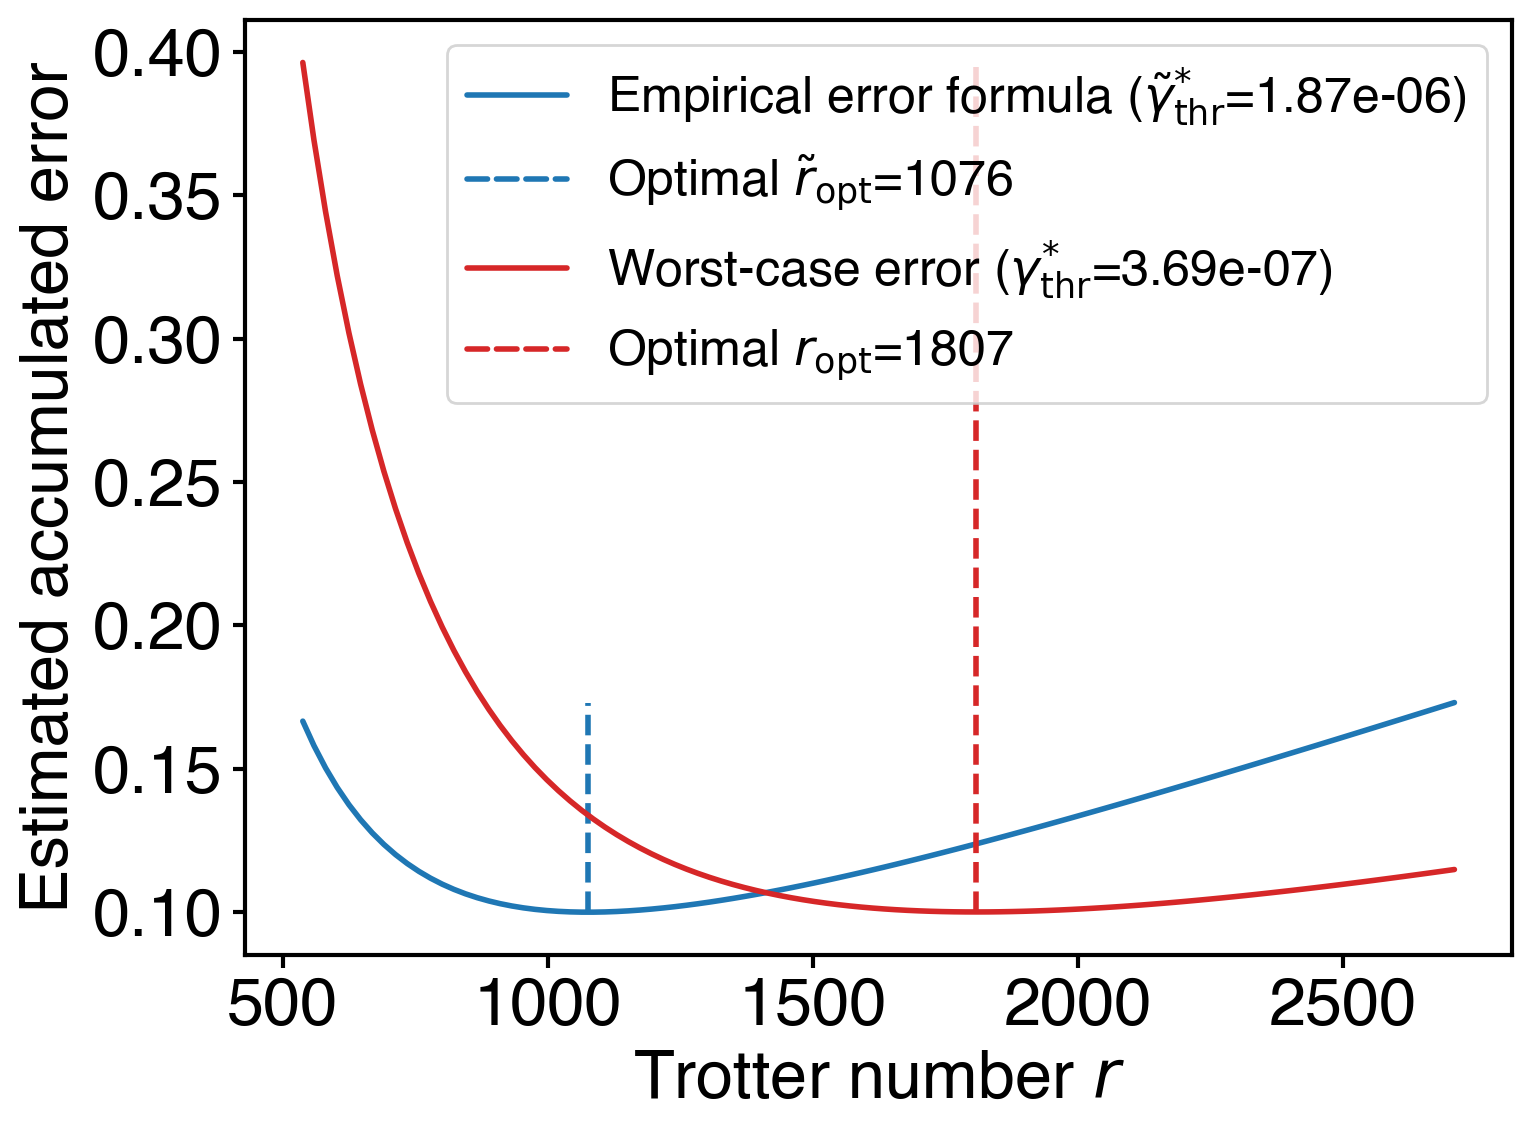

In [7]:
# n, p, t = 10, 2, 10
# n, p, gamma, r, t = 10, 2, 0.0001, 100, 10
# n, p, gamma, r, t = 200, 2, gamma_threshold_our, 100, 10
n, p, gamma, r, t = 50, 2, gamma_threshold_our, 100, 10
# n, p, gamma, r, t = 10, 2, 0.00001, 100, 10
emp_err_formula = Empirical_Error_Formula(fitted_coeff)
# binary search for optimal r
r_min, r_max = int(r_opt_our * 0.5), int(r_opt_worst * 1.5)
r_list = np.linspace(r_min, r_max, 100, dtype=int)
emp_err_list = [emp_err_formula.accumulated_tot_err(n, p, gamma_threshold_our, t, r, verbose=True) for r in r_list]
acc_err = partial(emp_err_formula.accumulated_tot_err, n, p, gamma_threshold_our, t)
emp_r_star = binary_search_opt_r(acc_err, r_min, r_max)
print(f"Optimal r*: {emp_r_star}, error: {acc_err(emp_r_star)}")

# worst-case
comm_norm = comm_norm_fitted
worst_err_list = [worst_case_err(n, t, p, comm_norm, gamma_threshold_worst, r) for r in r_list]
worst_acc_err = partial(worst_case_err, n, t, p, comm_norm, gamma_threshold_worst)
worst_r_star = binary_search_opt_r(worst_acc_err, r_min, r_max)

fig, ax = plt.subplots()
ax.plot(r_list, emp_err_list, label=fr'Empirical error formula ($\tilde{{\gamma}}_{{\mathrm{{thr}}}}^{{*}}$={gamma_threshold_our:.2e})', color='tab:blue')
ax.vlines(emp_r_star, acc_err(emp_r_star), max(emp_err_list), 'tab:blue', '--', label=fr'Optimal $\tilde{{r}}_{{\mathrm{{opt}}}}$={emp_r_star}')

ax.plot(r_list, worst_err_list, label=fr'Worst-case error ($\gamma_{{\mathrm{{thr}}}}^{{*}}$={gamma_threshold_worst:.2e})', color='tab:red')  
ax.vlines(worst_r_star, min(worst_err_list), max(worst_err_list), 'tab:red', '--', label=fr'Optimal $r_{{\mathrm{{opt}}}}$={worst_r_star}')
# print('worst-case: ', worst_case_err(n, r, t, p, H_list, gamma))

ax.legend()
ax.set_xlabel(f'Trotter number $r$')
ax.set_ylabel(f'Estimated accumulated error')
fig.savefig(f'{fig_dir}/gamma_threshold_compare_n={n}.pdf', bbox_inches='tight')

## QECC resource (#physical qubits) saving

In [8]:
def phy_qubit_diff(threshold_rate, logical_rate):
    return 2 * log(logical_rate, threshold_rate)

# r_relax_list = [661-497, 1385-1105, 2768-2237]
# logical_relax_list = [0.5/2.11, 0.48/1.49, 0.6/2.40]
r_relax_list = [823-584, 1807-1076, 3609-2053]
logical_relax_list = [0.4/1.69, 0.37/1.87, 0.46/2.46]
print(r_relax_list)
[phy_qubit_diff(0.5, logical_relax) for logical_relax in logical_relax_list]

[239, 731, 1556]


[4.1579026827896435, 4.674882188517374, 4.837905098564454]

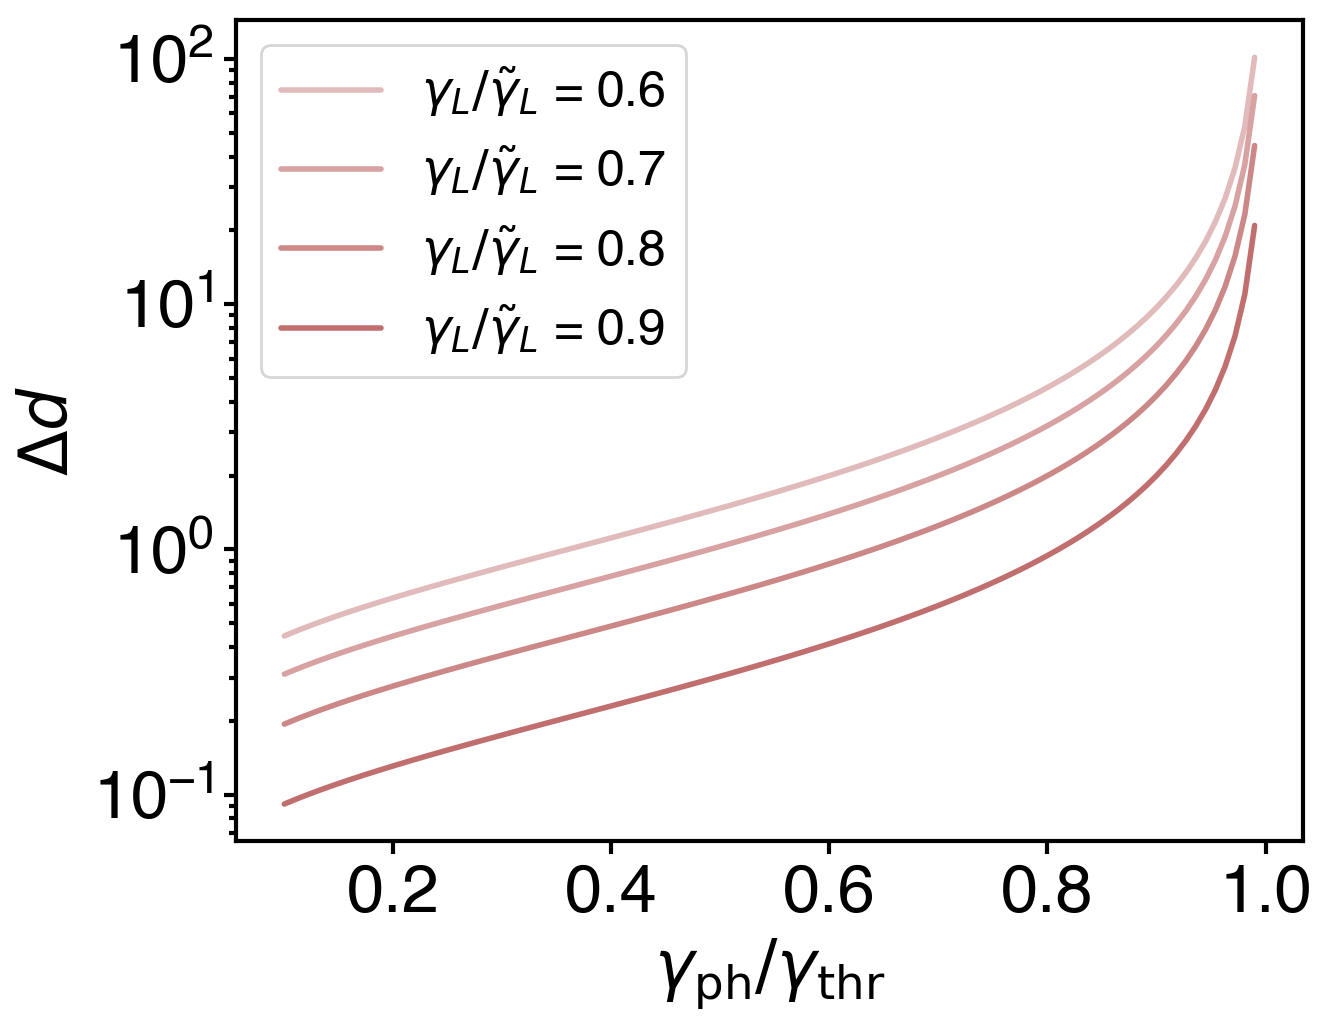

In [9]:
def phy_qubit_diff(threshold_ratio, logical_ratio):
    return 2 * log(logical_ratio, threshold_ratio)

threshold_rate_list = np.linspace(0.1, 0.99, 100)
# threshold_rate_list = np.linspace(0.5, 0.99, 100)
logical_rate_list = np.array([0.6, 0.7, 0.8, 0.9])
# apply the function to every elements in both arrays
phy_qubit_diff_list = [[2*log(logical_rate, threshold_rate) for threshold_rate in threshold_rate_list] for logical_rate in logical_rate_list]
# phy_qubit_diff_list = [[phy_qubit_diff(threshold_rate, logical_rate) for threshold_rate in threshold_rate_list] for logical_rate in logical_rate_list]

fig, ax = plt.subplots(figsize=(7, 5.5))
for i, threshold_rate in enumerate(logical_rate_list):
    ax.plot(threshold_rate_list, phy_qubit_diff_list[i], '-', label=rf'$\gamma_L/\tilde{{\gamma}}_L$ = {threshold_rate}', color='#B65655', alpha=0.4 + 0.6 * (i / len(logical_rate_list)))
ax.set_xlabel(r'$\gamma_{{\mathrm{ph}}}/\gamma_{{\mathrm{thr}}}$')
ax.set_ylabel(r'$\Delta d$')
# ax.set_ylabel(r'$\sqrt{{N_c}}-\sqrt{{\tilde{{N}}_c}}$')
ax.set_yscale('log')
ax.legend()
fig.savefig(f'{fig_dir}/qecc_diff.pdf', bbox_inches='tight')

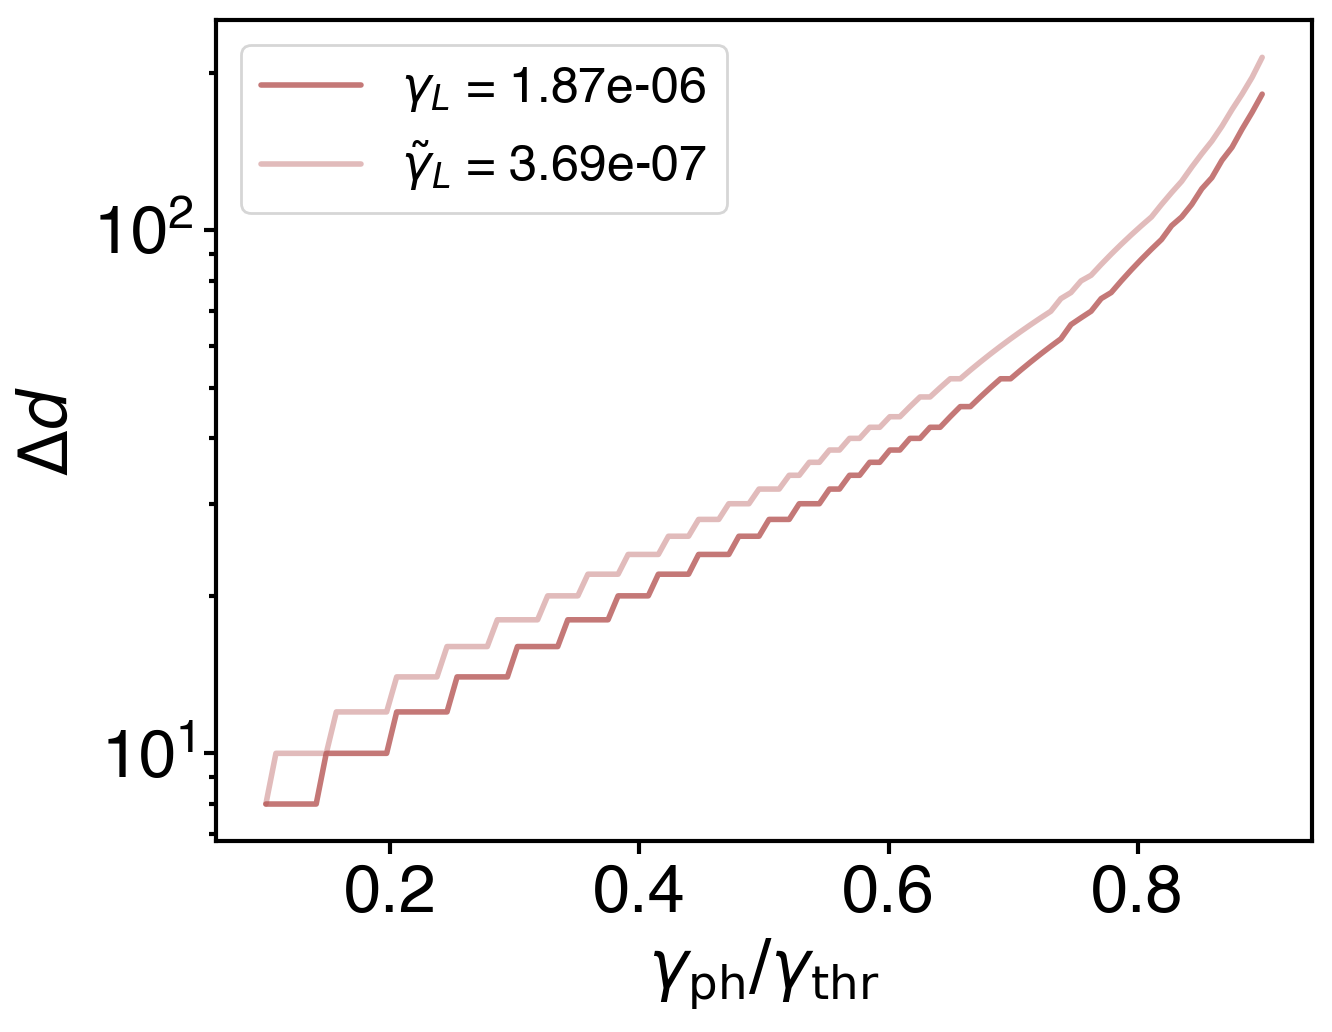

In [10]:
## explicit difference
def phy_qubit_explicit(threshold_ratio, logical_rate, const=0.02985):
    return 2 * int(log(logical_rate / const, threshold_ratio))

threshold_ratio_list = np.linspace(0.1, 0.9, 100)
logical_worst, logical_depen = 1.87*10**(-6), 3.69*10**(-7)
phy_qubit_worst_list = [phy_qubit_explicit(threshold_ratio, logical_worst) for threshold_ratio in threshold_ratio_list]
phy_qubit_depen_list = [phy_qubit_explicit(threshold_ratio, logical_depen) for threshold_ratio in threshold_ratio_list]

fig, ax = plt.subplots(figsize=(7, 5.5))
ax.plot(threshold_ratio_list, phy_qubit_worst_list, '-', label=rf'$\gamma_L$ = {logical_worst}', color='#B65655', alpha=0.8)
ax.plot(threshold_ratio_list, phy_qubit_depen_list, '-', label=rf'$\tilde{{\gamma}}_L$ = {logical_depen}', color='#B65655', alpha=0.4)
ax.set_xlabel(r'$\gamma_{{\mathrm{ph}}}/\gamma_{{\mathrm{thr}}}$')
ax.set_ylabel(r'$\Delta d$')
# ax.set_ylabel(r'$\sqrt{{N_c}}-\sqrt{{\tilde{{N}}_c}}$')
ax.set_yscale('log')
ax.legend()
fig.savefig(f'{fig_dir}/qecc_diff_explicit.pdf', bbox_inches='tight')

## Merge two figures

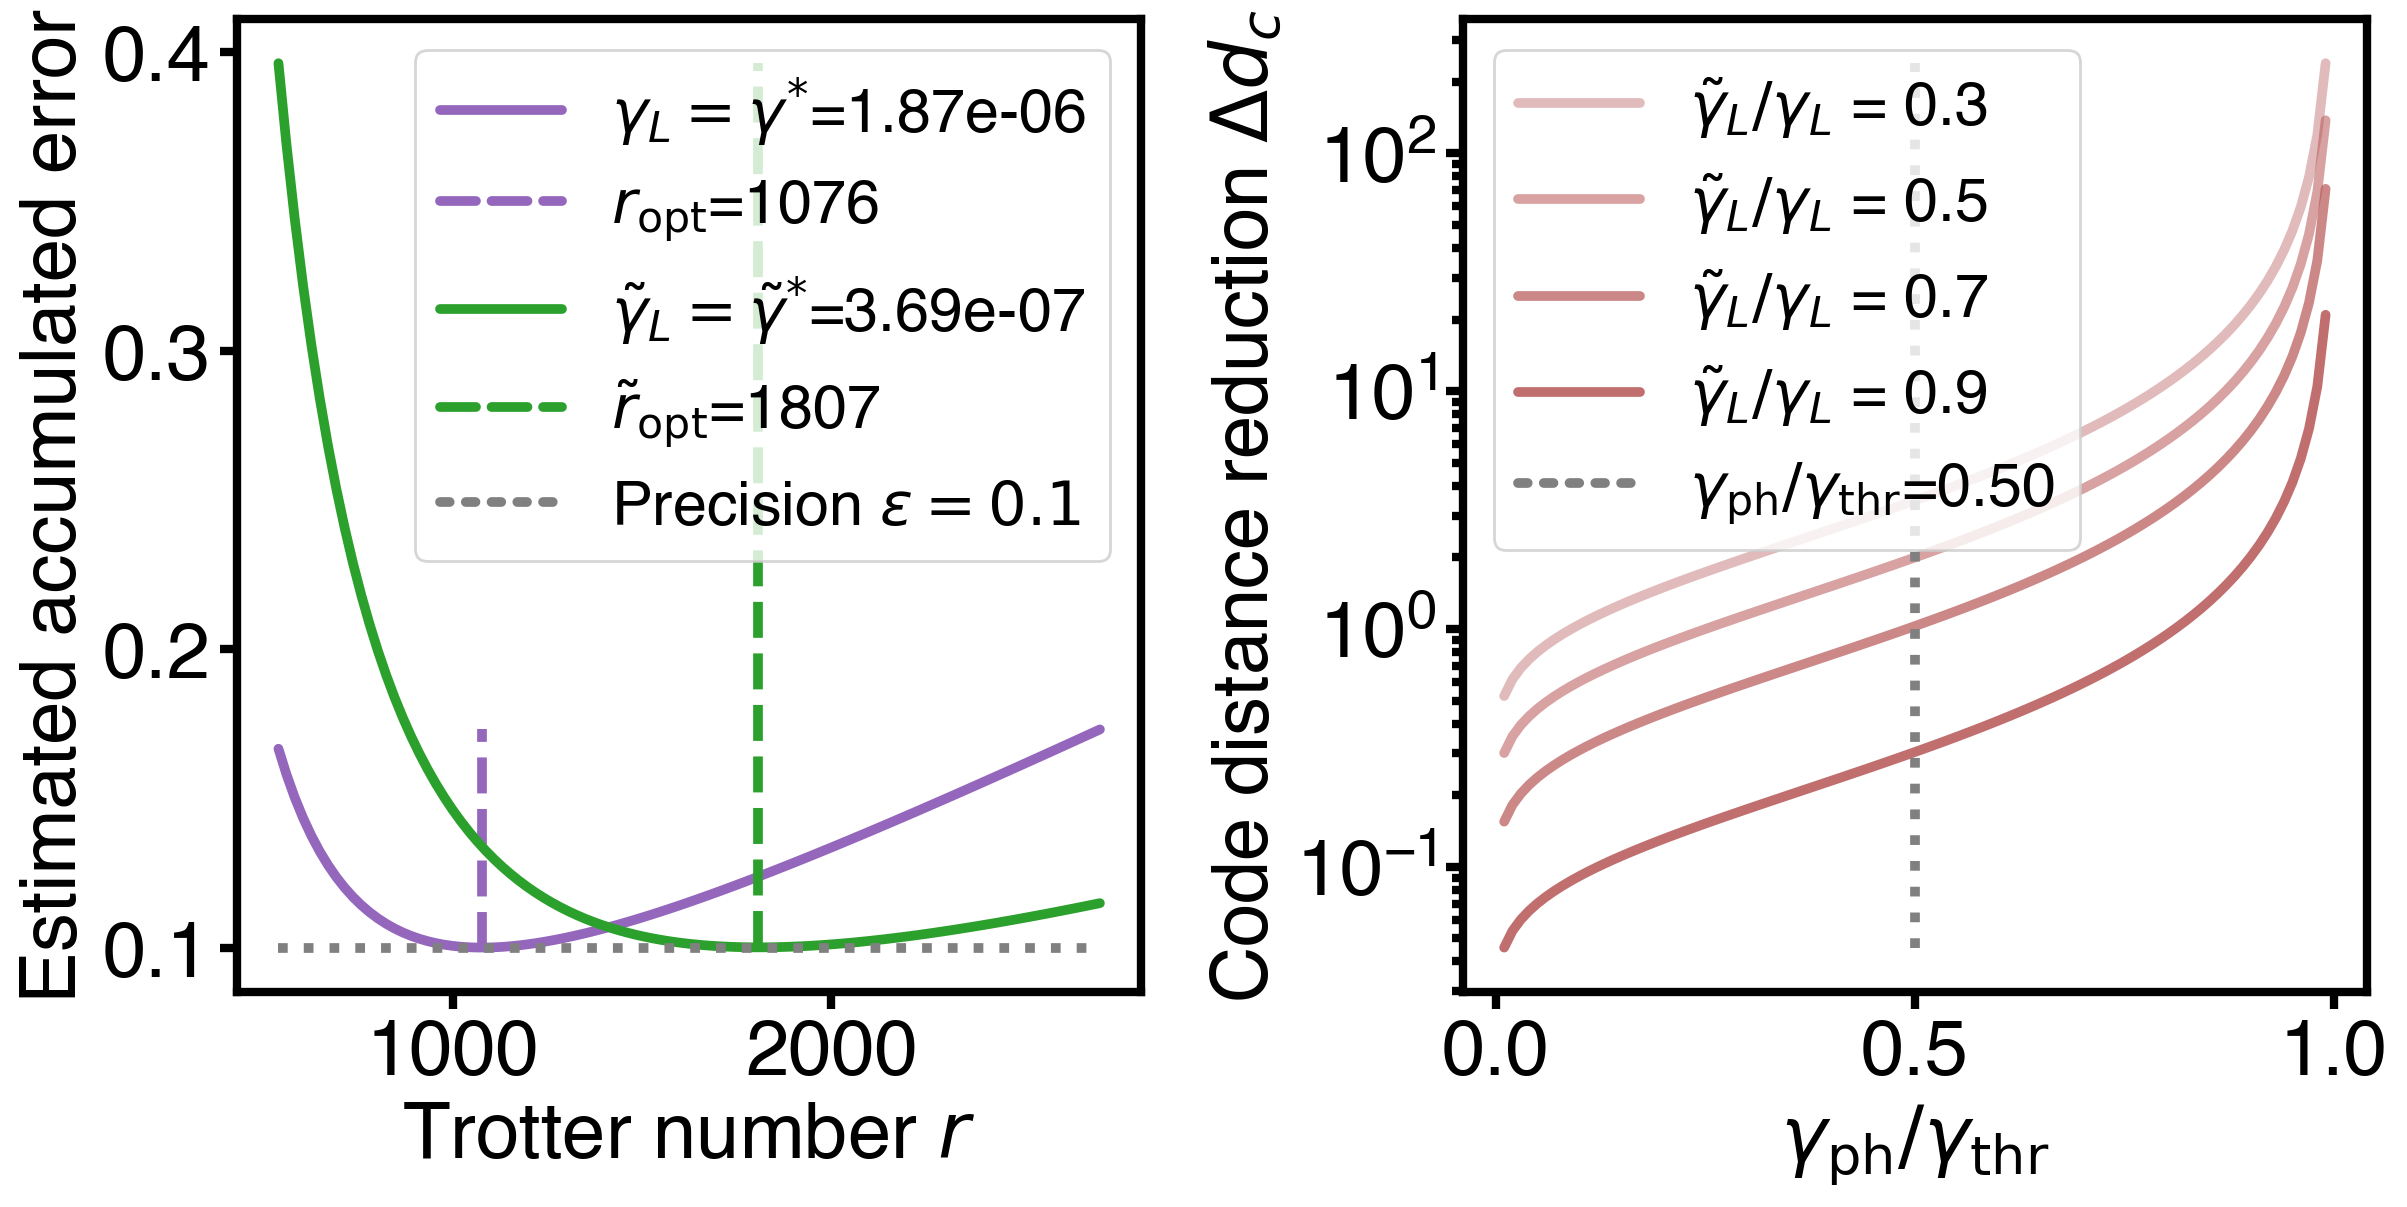

In [11]:
set_fontsize(medium=MEDIUM_SIZE+4, large=LARGE_SIZE+4, linewidth=3.0)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12.5, 6.5))
ax1.plot(r_list, emp_err_list, label=fr'$\gamma_{{L}}=\gamma^{{*}}$={gamma_threshold_our:.2e}', color='#9467bdFF')
# ax1.plot(r_list, emp_err_list, label=fr'Empirical error formula ($\tilde{{\gamma}}_{{\mathrm{{thr}}}}$={gamma_threshold:.2e})', color='tab:blue')
ax1.vlines(emp_r_star, acc_err(emp_r_star), max(emp_err_list), '#9467bdFF', '--', label=fr'$r_{{\mathrm{{opt}}}}$={emp_r_star}')

ax1.plot(r_list, worst_err_list, label=fr'$\tilde{{\gamma}}_{{L}}=\tilde{{\gamma}}^{{*}}$={gamma_threshold_worst:.2e}', color='#2ca02cFF')  
ax1.vlines(worst_r_star, min(worst_err_list), max(worst_err_list), '#2ca02cFF', '--', label=fr'$\tilde{{r}}_{{\mathrm{{opt}}}}$={worst_r_star}')
ax1.hlines(0.1, r_min, r_max, 'gray', ':', label=rf'Precision $\epsilon=0.1$')
# print('worst-case: ', worst_case_err(n, r, t, p, H_list, gamma))

ax1.legend()
ax1.set_xlabel(f'Trotter number $r$')
ax1.set_ylabel(f'Estimated accumulated error')

# threshold_rate_list = np.linspace(0.5, 0.99, 100)
threshold_rate_list = np.linspace(0.01, 0.99, 100)
# threshold_rate_list = np.linspace(0.6, 0.99, 100)
# logical_rate_list = np.array([0.6, 0.7, 0.8, 0.9])
logical_rate_list = np.array([0.3, 0.5, 0.7, 0.9])
# apply the function to every elements in both arrays
phy_qubit_diff_list = [[2*log(logical_rate, threshold_rate) for threshold_rate in threshold_rate_list] for logical_rate in logical_rate_list]

for i, threshold_rate in enumerate(logical_rate_list):
    ax2.plot(threshold_rate_list, phy_qubit_diff_list[i], '-', label=rf'$\tilde{{\gamma}}_L/\gamma_L$ = {threshold_rate}', color='#B65655', alpha=0.4 + 0.6 * (i / len(logical_rate_list)))

sota_gamma_ph_thr = 0.50
ax2.vlines(sota_gamma_ph_thr, min(phy_qubit_diff_list[-1]), max(phy_qubit_diff_list[0]), 'gray', ':', label=fr'$\gamma_{{\mathrm{{ph}}}}/\gamma_{{\mathrm{{thr}}}}$={sota_gamma_ph_thr:.2f}')
# ax2.set_xticks([0.6, 0.8, sota_gamma_ph_thr])
ax2.set_xlabel(r'$\gamma_{{\mathrm{ph}}}/\gamma_{{\mathrm{thr}}}$')
ax2.set_ylabel(r'Code distance reduction $\Delta d_c$')
# ax2.set_ylabel(r'$\sqrt{{N_c}}-\sqrt{{\tilde{{N}}_c}}$')
ax2.set_yscale('log')
ax2.legend()
# ax1.text(-0.15, 1.05, '(a)', transform=ax1.transAxes, fontsize=28, weight='bold')
# ax2.text(-0.15, 1.05, '(b)', transform=ax2.transAxes, fontsize=28, weight='bold')
fig.savefig(f'{fig_dir}/resource_saving_n={n}.pdf', bbox_inches='tight')

In [24]:
def phy_qubit_explicit(threshold_ratio, logical_rate, const=0.02985):
    d_c = 2 * int(log(logical_rate / const, threshold_ratio))
    return d_c**2

sota_gamma_ph_thr = 0.50

r_worst_list = [823, 1807, 3609]
r_depen_list = [584, 1076, 2053]
logical_worst_list = [4.05e-6, 3.69e-7, 4.60e-8]
logical_depen_list = [1.69e-5, 1.87e-6, 2.46e-7]
phy_n_worst_list = [phy_qubit_explicit(sota_gamma_ph_thr, logical_worst) for logical_worst in logical_worst_list]
phy_n_depen_list = [phy_qubit_explicit(sota_gamma_ph_thr, logical_depen) for logical_depen in logical_depen_list]
print('Nc (worst):',phy_n_worst_list)
print('Nc (depen):',phy_n_depen_list)
print('r (worst):',r_worst_list)
print('r (depen):',r_depen_list)

# print(np.array(phy_n_worst_list) - np.array(phy_n_depen_list))
for i in range(len(r_worst_list)):
    worst_rn = r_worst_list[i]*phy_n_worst_list[i]
    depen_rn = r_depen_list[i]*phy_n_depen_list[i]
    print('r*N_c (worst - ours):',  worst_rn - depen_rn, (worst_rn-depen_rn)/worst_rn)

Nc (worst): [576, 1024, 1444]
Nc (depen): [400, 676, 1024]
r (worst): [823, 1807, 3609]
r (depen): [584, 1076, 2053]
r*N_c (worst - ours): 240448 0.5072228972593492
r*N_c (worst - ours): 1122992 0.6069019784172662
r*N_c (worst - ours): 3109124 0.5966009875281019


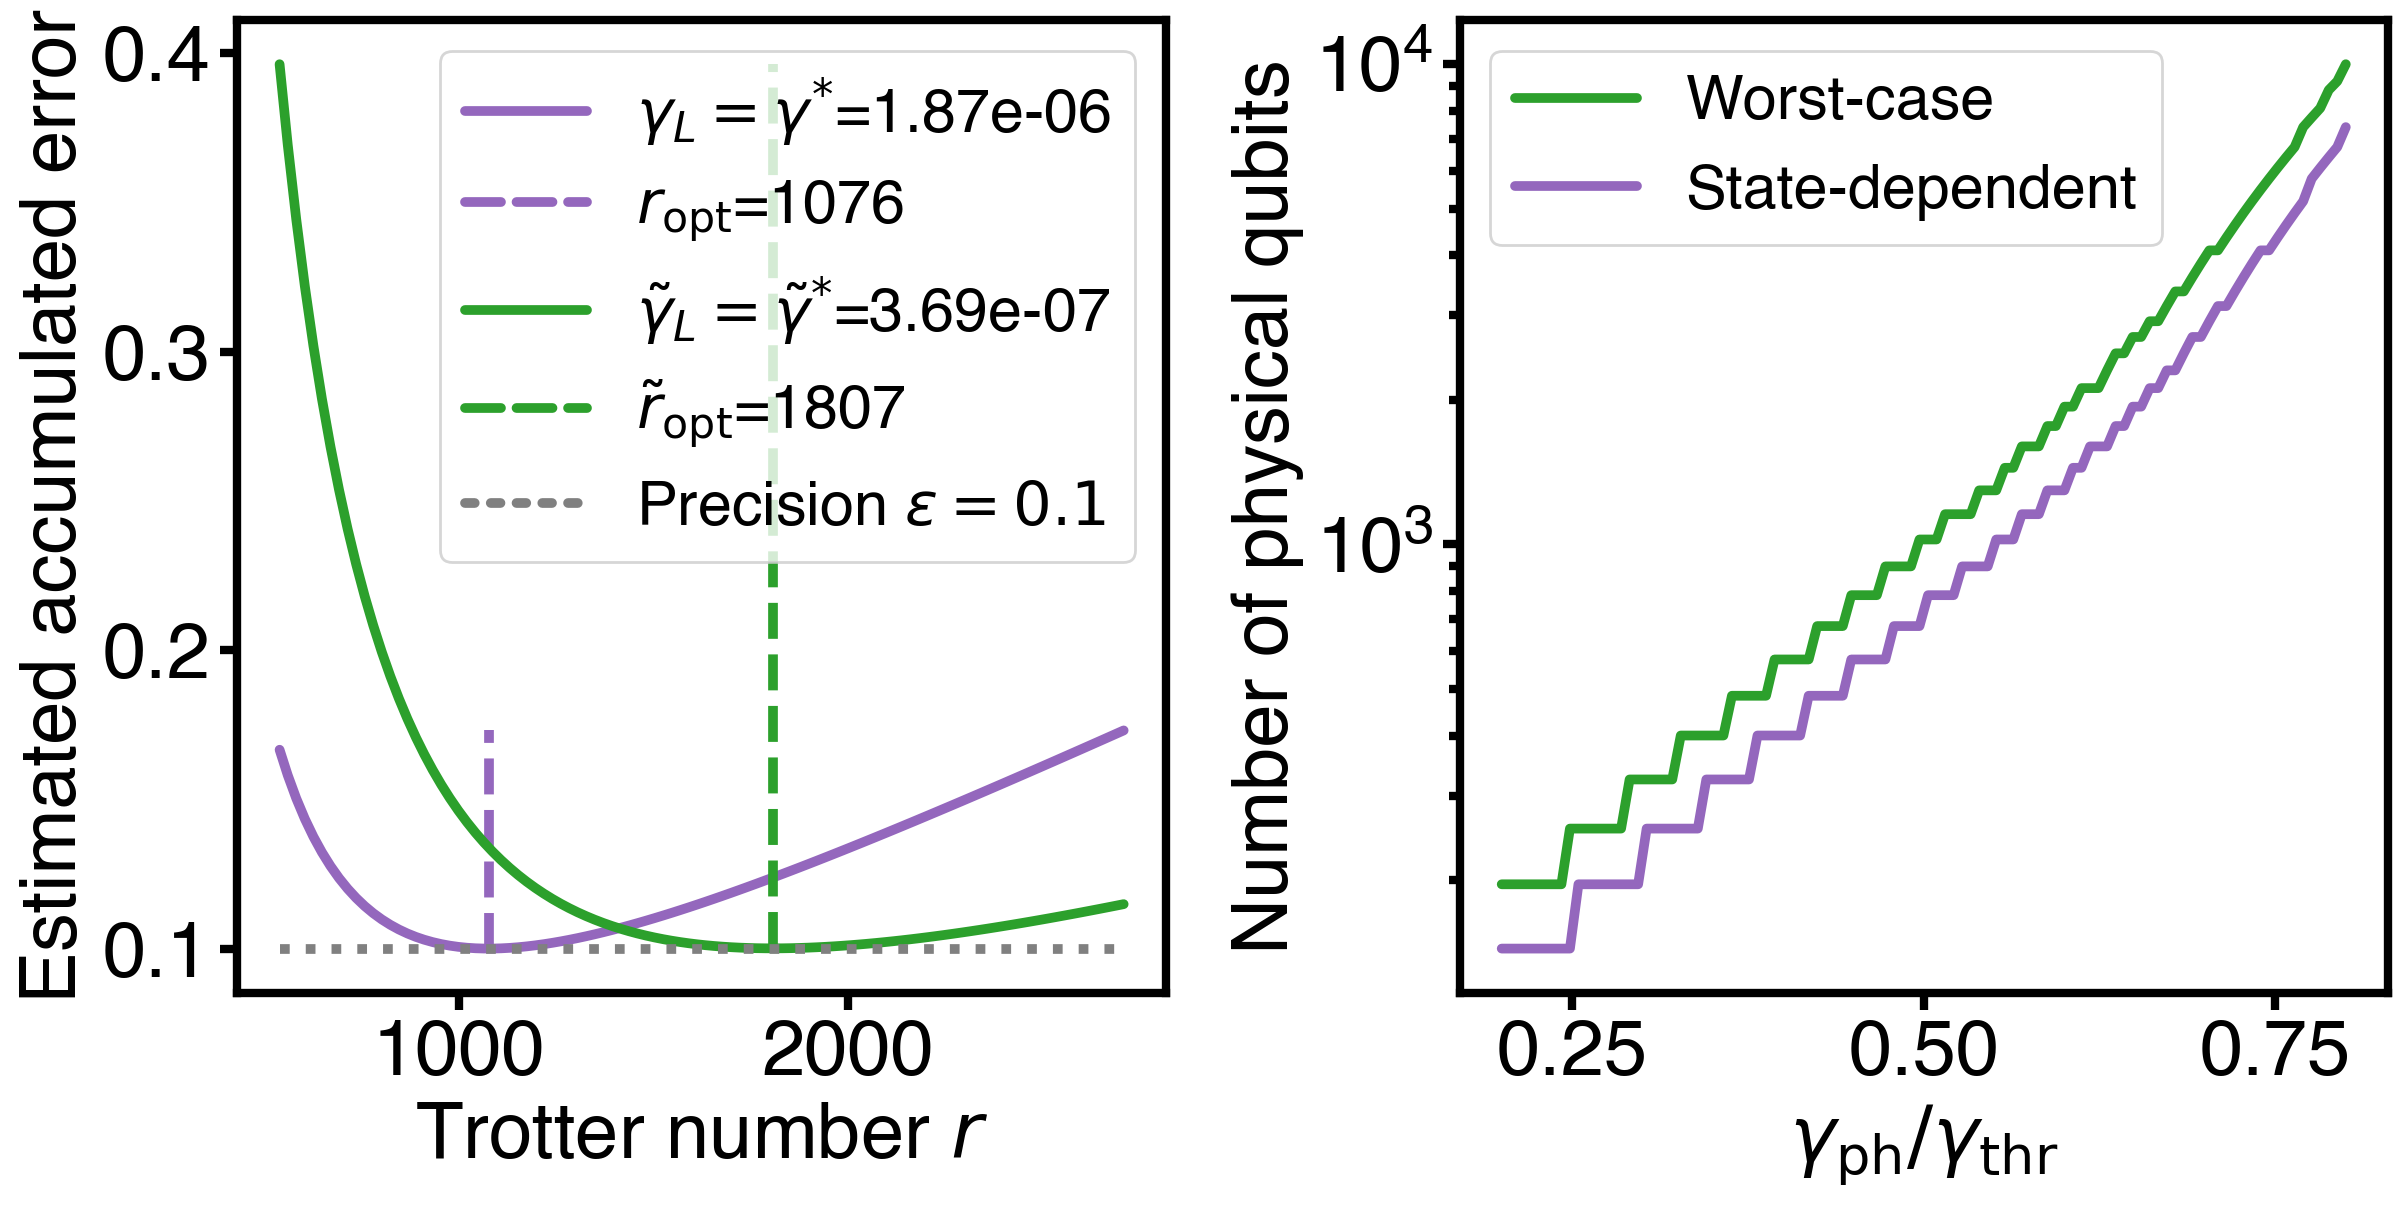

In [18]:
set_fontsize(medium=MEDIUM_SIZE+4, large=LARGE_SIZE+4, linewidth=3.0)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12.5, 6.5))
ax1.plot(r_list, emp_err_list, label=fr'$\gamma_{{L}}=\gamma^{{*}}$={gamma_threshold_our:.2e}', color='#9467bdFF')
ax1.vlines(emp_r_star, acc_err(emp_r_star), max(emp_err_list), '#9467bdFF', '--', label=fr'$r_{{\mathrm{{opt}}}}$={emp_r_star}')

ax1.plot(r_list, worst_err_list, label=fr'$\tilde{{\gamma}}_{{L}}=\tilde{{\gamma}}^{{*}}$={gamma_threshold_worst:.2e}', color='#2ca02cFF')  
ax1.vlines(worst_r_star, min(worst_err_list), max(worst_err_list), '#2ca02cFF', '--', label=fr'$\tilde{{r}}_{{\mathrm{{opt}}}}$={worst_r_star}')
ax1.hlines(0.1, r_min, r_max, 'gray', ':', label=rf'Precision $\epsilon=0.1$')
# print('worst-case: ', worst_case_err(n, r, t, p, H_list, gamma))

ax1.legend()
ax1.set_xlabel(f'Trotter number $r$')
ax1.set_ylabel(f'Estimated accumulated error')

threshold_ratio_list = np.linspace(0.2, 0.8, 100)
logical_depen, logical_worst = 1.87*10**(-6), 3.69*10**(-7)
phy_qubit_worst_list = [phy_qubit_explicit(threshold_ratio, logical_worst) for threshold_ratio in threshold_ratio_list]
phy_qubit_depen_list = [phy_qubit_explicit(threshold_ratio, logical_depen) for threshold_ratio in threshold_ratio_list]

ax2.plot(threshold_ratio_list, phy_qubit_worst_list, '-', label=rf'Worst-case', color='#2ca02cFF', alpha=1.0)
ax2.plot(threshold_ratio_list, phy_qubit_depen_list, '-', label=rf'State-dependent', color='#9467bdFF', alpha=1.0)
# ax2.plot(threshold_ratio_list, phy_qubit_worst_list, '-', label=rf'$\gamma$ = {logical_worst}', color='#9467bdFF', alpha=1.0)
# ax2.plot(threshold_ratio_list, phy_qubit_depen_list, '-', label=rf'$\tilde{{\gamma}}$ = {logical_depen}', color='#2ca02cFF', alpha=1.0)
ax2.set_xlabel(r'$\gamma_{{\mathrm{ph}}}/\gamma_{{\mathrm{thr}}}$')
ax2.set_ylabel(r'Number of physical qubits')
ax2.set_yscale('log')
ax2.legend()
fig.savefig(f'{fig_dir}/resource_saving_n={n}_explicit.pdf', bbox_inches='tight')

In [54]:
6558.65+6499.53+5324

18382.18

In [6]:
import math
math.sin(0.03)

0.02999550020249566